# Lab 5: Spam Detection

**Deadline**: Thursday, Nov 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Geoff Donoghue 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1rReXth8IGYuUzUQR4DPMtLz0J4H22e2I?usp=sharing

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [6]:
#mount googledrive
from google.colab import drive
drive.mount('/content/drive')

# location on Google Drive
path = '/content/drive/My Drive/Colab Notebooks/aps360/Lab5/smsspamcollection/'

Mounted at /content/drive


In [7]:
! cd /content/drive/"My Drive"/"Colab Notebooks"/aps360/"Lab5"/smsspamcollection && ls -la

total 473
-rw------- 1 root root   5868 Apr 18  2011 readme
-rw------- 1 root root 477907 Mar 15  2011 SMSSpamCollection


In [8]:
count = 0

for line in open(path+'SMSSpamCollection'):
    print(line)
    count+=1
    if (count == 50):
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

ham	Even my brother is not like to speak with me. They treat me like aids patent.

ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only

In [9]:
# Label for spam: spam
# Label for non-spam: ham

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [10]:
spam_count = 0
ham_count = 0
total_count = 0

for line in open(path+'SMSSpamCollection'):
    if (line[0:4] == 'spam'):
      spam_count+=1
      total_count+=1
    else:
      ham_count+=1
      total_count+=1

print("Spam count:", spam_count)
print("Nospam count:", ham_count)
print("Total count:", total_count)

Spam count: 747
Nospam count: 4827
Total count: 5574


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [10]:
"""

Advantages:
1. Can replicate grammatically correct sequences for a wide range of languages
2. Smaller discrete space to deal with (ie: 97 eng characters including punctuations)
3. Less memory requirement (because no need consider individual unique words, just chars)

Disadvantages:
1. Require bigger hidden layer
2. Computationally heavy and longer training
3. Lower accuracy because larger pool of prediction

"""

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [11]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(path+'SMSSpamCollection', # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [12]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [13]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<function _default_unk_index at 0x7f6b490c5400>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'T': 25, 'b': 26, '2': 27, '8': 28, 'k': 29, '5': 30, 'E': 31, 'v': 32, 'S': 33, 'C': 34, 'I': 35, 'O': 36, 'N': 37, '4': 38, 'x': 39, '7': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'W': 48, 'P': 49, 'U': 50, 'H': 51, 'M': 52, 'L': 53, 'D': 54, 'Y': 55, 'B': 56, 'G': 57, '/': 58, "'": 59, 'F': 60, '?': 61, '£': 62, '&': 63, '-': 64, 'X': 65, ':': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'q': 77, '"': 78, '#': 79, 'Q': 80, '@': 81, '=': 82, 'ü': 83, 'Z': 84, '>': 85, 'Ü': 86, '\x92': 87, '‘': 88, '_': 89, '[': 90, ']': 91, '|': 92, '%': 93, '$': 94, '<': 95, '¡': 96, '“': 97, '–': 98, '…': 99, '\x93': 100, '\\': 101, '\t': 102, '\

In [ ]:
# text_field.vocab.stoi - A collections.defaultdict instance (dictionary) mapping token strings to numerical identifiers
# text_field.vocab.itos - A list of token strings indexed by their numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [14]:
# unk: unknown, used word not found in vocabulary list
# pad: padding, represents padding

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [24]:
def get_data_loader():
  train_iter = torchtext.data.BucketIterator(train,
                                            batch_size=32,
                                            sort_key=lambda x: len(x.sms), # to minimize padding
                                            sort_within_batch=True,        # sort within each batch
                                            repeat=False)                  # repeat the iterator for many epochs

  valid_iter = torchtext.data.BucketIterator(valid,
                                            batch_size=32,
                                            sort_key=lambda x: len(x.sms), # to minimize padding
                                            sort_within_batch=True,        # sort within each batch
                                            repeat=False)                  # repeat the iterator for many epochs

  test_iter = torchtext.data.BucketIterator (test,
                                            batch_size=32,
                                            sort_key=lambda x: len(x.sms), # to minimize padding
                                            sort_within_batch=True,        # sort within each batch
                                            repeat=False)                  # repeat the iterator for many epochs

  return train_iter, valid_iter, test_iter

In [ ]:
train_iter, valid_iter, test_iter = get_data_loader()

In [16]:
count = 0

pad_index = torch.tensor([text_field.vocab.stoi['<pad>']])

for batch in train_iter:
    count+=1

    pad_count = 0
    max_length = 0

    for i in range(len(batch.sms[0])):
        current_length = 0

        for j in range(len(batch.sms[0][i])):
            max_length = max(max_length, current_length)

            if batch.sms[0][i][j] == pad_index:
              pad_count += 1
              current_length = 0
            else:
              current_length += 1

    print("Batch #", count)
    print("pad_count:", pad_count)
    print("pad_count", max_length)
    print()

    if (count==10):
      break

Batch # 1
pad_count: 25
pad_count 69

Batch # 2
pad_count: 18
pad_count 105

Batch # 3
pad_count: 31
pad_count 159

Batch # 4
pad_count: 3
pad_count 21

Batch # 5
pad_count: 14174
pad_count 789

Batch # 6
pad_count: 3
pad_count 142

Batch # 7
pad_count: 12
pad_count 30

Batch # 8
pad_count: 0
pad_count 157

Batch # 9
pad_count: 939
pad_count 225

Batch # 10
pad_count: 37
pad_count 58



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [17]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [18]:
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [34]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for txts, labels in data:
        output = model(txts[0])
        output = output.max(1, keepdim=True)[1]
        correct += output.eq(labels.view_as(output)).sum().item()
        total += labels.shape[0]
    return float(correct / total)


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [48]:
def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5, plot=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torchtext.data.BucketIterator(train,
                            batch_size=batch_size,
                            sort_key=lambda x: len(x.sms), # to minimize padding
                            sort_within_batch=True, # sort within each batch
                            repeat=False) # repeat the iterator for many epochs

    valid_loader = torchtext.data.BucketIterator(valid,
                            batch_size=batch_size,
                            sort_key=lambda x: len(x.sms), # to minimize padding
                            sort_within_batch=True, # sort within each batch
                            repeat=False) # repeat the iterator for many epochs
    
    print ("Training Started...")
    start_time = time.time()

    if plot:

      train_acc, train_loss, val_acc, val_loss = [], [], [], []
      
      # training
      for epoch in range(num_epochs):
        for batch in train_loader:
          optimizer.zero_grad()
          pred = model(batch.sms[0])
          loss = criterion(pred, batch.label)
          loss.backward()
          optimizer.step()

        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        train_loss.append(loss)

        # print("epoch: ", epoch, end = " ")
        # print("train acc: ", train_acc[-1], end = " ")
        # print("val acc: ", val_acc[-1])
        print("epoch:", epoch, "| train acc:", train_acc[-1], "| val acc:", val_acc[-1])

      # Plotting
      plt.title("Training Loss")
      plt.plot(train_loss, label="Train")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      plt.title("Training vs Validation Accuracy")
      plt.plot(train_acc, label="Train")
      plt.plot(val_acc, label="Validation")
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()

      # Printing final results
      print("Final Train Accuracy:", get_accuracy(model, train_loader))
      print("Final Valid Accuracy:", get_accuracy(model, valid_loader))
    
    else:

      # training
      for epoch in range(num_epochs):
        for batch in train_loader:
          optimizer.zero_grad()
          pred = model(batch.sms[0])
          loss = criterion(pred, batch.label)
          loss.backward()
          optimizer.step()

        # print("epoch: ", epoch, end = " ")
        # print("train acc: ", get_accuracy(model, train_loader), end = " ")
        # print("val acc: ", get_accuracy(model, valid))
        print("epoch:", epoch)
      
      # Printing final results
      print("Final Train Accuracy:", get_accuracy(model, train_loader))
      print("Final Valid Accuracy:", get_accuracy(model, valid_loader))

    end_time = time.time()
    print("Training took:", (end_time-start_time)/60, "minutes")

Training Started...
epoch: 0 | train acc: 0.48390325271059215 | val acc: 0.8582959641255605
epoch: 1 | train acc: 0.48390325271059215 | val acc: 0.8582959641255605
epoch: 2 | train acc: 0.6798999165971643 | val acc: 0.9031390134529148
epoch: 3 | train acc: 0.9125938281901584 | val acc: 0.8798206278026905
epoch: 4 | train acc: 0.9125938281901584 | val acc: 0.8825112107623319
epoch: 5 | train acc: 0.939115929941618 | val acc: 0.9309417040358744
epoch: 6 | train acc: 0.9396163469557965 | val acc: 0.9461883408071748
epoch: 7 | train acc: 0.9472894078398666 | val acc: 0.9551569506726457
epoch: 8 | train acc: 0.9452877397831526 | val acc: 0.9560538116591928
epoch: 9 | train acc: 0.948790658882402 | val acc: 0.9605381165919282
epoch: 10 | train acc: 0.9544620517097582 | val acc: 0.957847533632287
epoch: 11 | train acc: 0.954628857381151 | val acc: 0.957847533632287
epoch: 12 | train acc: 0.946955796497081 | val acc: 0.9614349775784753
epoch: 13 | train acc: 0.9567973311092577 | val acc: 0.962

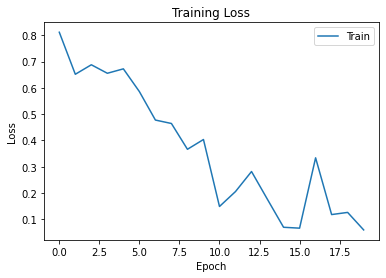

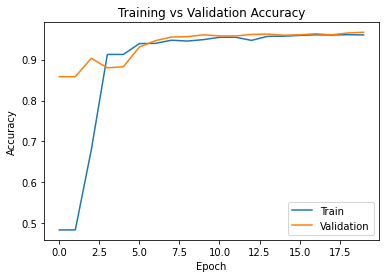

Final Train Accuracy: 0.9597998331943286
Final Valid Accuracy: 0.9659192825112107
Training took: 2.559452704588572 min


In [47]:
model_base = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_base, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4, plot=True)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [60]:
# I'm going to use base model as my base case and work on improving the accuracy from there
# I'm going to increase the batch_size to try to increase the accuracy
# It wasn't very helpful, I'm going to stick to baychsize of 32

model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=64, num_epochs=20, learning_rate=1e-4, plot=False)

Training Started...
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
Final Train Accuracy: 0.9494578815679733
Final Valid Accuracy: 0.9524663677130045
Training took: 1.1004063010215759 minutes


In [49]:
# trying a larger learning rate, just incase the model is stuck at a local minimum

model_2 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_2, train, valid, batch_size=32, num_epochs=20, learning_rate=5e-4, plot=False)

Training Started...
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
Final Train Accuracy: 0.9718098415346121
Final Valid Accuracy: 0.9766816143497757
Training took: 1.7075273553530375 minutes


In [ ]:
# increasing epoch

model_3 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_3, train, valid, batch_size=32, num_epochs=60, learning_rate=1e-4, plot=False)

Training Started...
epoch: 0 | train acc: 0.5160967472894078 | val acc: 0.14170403587443947
epoch: 1 | train acc: 0.5229357798165137 | val acc: 0.1515695067264574
epoch: 2 | train acc: 0.8677231025854879 | val acc: 0.7946188340807175
epoch: 3 | train acc: 0.9349457881567973 | val acc: 0.9300448430493273
epoch: 4 | train acc: 0.9444537114261885 | val acc: 0.95695067264574
epoch: 5 | train acc: 0.9492910758965805 | val acc: 0.9524663677130045
epoch: 6 | train acc: 0.9524603836530442 | val acc: 0.9641255605381166
epoch: 7 | train acc: 0.9506255212677232 | val acc: 0.9695067264573991
epoch: 8 | train acc: 0.9539616346955796 | val acc: 0.9614349775784753
epoch: 9 | train acc: 0.9552960800667223 | val acc: 0.9695067264573991
epoch: 10 | train acc: 0.9571309424520433 | val acc: 0.968609865470852
epoch: 11 | train acc: 0.9561301084236864 | val acc: 0.9560538116591928
epoch: 12 | train acc: 0.9587989991659717 | val acc: 0.968609865470852
epoch: 13 | train acc: 0.9539616346955796 | val acc: 0.94

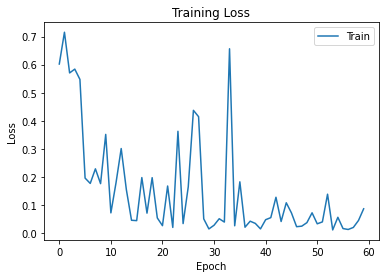

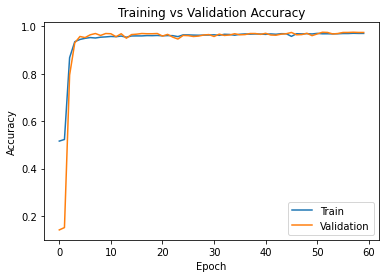

Final Train Accuracy: 0.9699749791492911
Final Valid Accuracy: 0.9739910313901345
Training took: 7.435846563180288 minutes


In [53]:
# increasing epoch (plot) to see if we need to. After observing the graph, we don't need to increase epoch more than 30

model_3a = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_3a, train, valid, batch_size=32, num_epochs=60, learning_rate=1e-4, plot=True)

In [51]:
# increasing hidden size to see how it changes (increasing perfomance of model)

model_4 = SpamRNN(input_size=len(text_field.vocab), hidden_size=40, num_classes=2)
train_rnn_network(model_4, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4, plot=False)

Training Started...
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
Final Train Accuracy: 0.972977481234362
Final Valid Accuracy: 0.9623318385650225
Training took: 1.9451248208681742 minutes


In [52]:
# decreasing hidden size to see how it changes (reducing performance of model)

model_5 = SpamRNN(input_size=len(text_field.vocab), hidden_size=10, num_classes=2)
train_rnn_network(model_5, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4, plot=False)

Training Started...
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
Final Train Accuracy: 0.9506255212677232
Final Valid Accuracy: 0.957847533632287
Training took: 1.6420012633005778 minutes


In [54]:
# trying to combine individual analysis from previous parts

model_6 = SpamRNN(input_size=len(text_field.vocab), hidden_size=40, num_classes=2)
train_rnn_network(model_6, train, valid, batch_size=32, num_epochs=30, learning_rate=5e-4, plot=False)

Training Started...
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
Final Train Accuracy: 0.9978315262718932
Final Valid Accuracy: 0.9766816143497757
Training took: 2.8702030102411906 minutes


In [ ]:
# Best is model_6 with the following parameteres
# model_6 = SpamRNN(input_size=len(text_field.vocab), hidden_size=40, num_classes=2)
# train_rnn_network(model_6, train, valid, batch_size=32, num_epochs=30, learning_rate=5e-4, plot=False)

# with test accuracy of 0.99 and val accuracy of 0.97-

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [63]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                                batch_size=32,
                                                sort_key=lambda x: len(x.sms), # to minimize padding
                                                sort_within_batch=True,        # sort within each batch
                                                repeat=False)                  # repeat the iterator for many epochs

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                                  batch_size=32,
                                                  sort_key=lambda x: len(x.sms), # to minimize padding
                                                  sort_within_batch=True,        # sort within each batch
                                                  repeat=False)                  # repeat the iterator for many epochs

valid_spam_accuracy = get_accuracy(model_6, valid_spam_iter)
valid_nospam_accuracy = get_accuracy(model_6, valid_nospam_iter)

# False Positive: Detects as spam when no spam
# False Negative: Detects as no spam when spam
print("False Positive Rate:", 1-valid_nospam_accuracy)
print("False Negative Rate:", 1-valid_spam_accuracy)

False Positive Rate: 0.017763845350052265
False Negative Rate: 0.05696202531645567


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
"""

Impact of False Positive:
 - An important message is detected as spam
 - Receipient will not receive the message, it could be some bank transaction notification, or work related update, or emergency texts from friends and family 
 - Not replying to the message (because it was detected as spam by phone) could raise some issues for the person

Imapact of False Negative
 - Message wrongly detected as NOT spam
 - This is just going to result in clustered inbox, basically the spam detection did not do the right thing, not a very significant issue where some important message is discarded 
 - It could also expose users to spam messages with links which might try to phish out information from user
 - But actual important messages like in False Postive example does not occur

"""

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [61]:
test_accuracy = get_accuracy(model_6, test_iter)
print("test acc:", test_accuracy)

test acc: 0.981149012567325


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [64]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                              batch_size=32,
                                              sort_key=lambda x: len(x.sms), # to minimize padding
                                              sort_within_batch=True,        # sort within each batch
                                              repeat=False)                  # repeat the iterator for many epochs

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                                batch_size=32,
                                                sort_key=lambda x: len(x.sms), # to minimize padding
                                                sort_within_batch=True,        # sort within each batch
                                                repeat=False)                  # repeat the iterator for many epochs

test_spam_accuracy = get_accuracy(model_6, test_spam_iter)
test_nospam_accuracy = get_accuracy(model_6, test_nospam_iter)

# False Positive: Detects as spam when no spam
# False Negative: Detects as no spam when spam
print("False Positive Rate:", 1-test_nospam_accuracy)
print("False Negative Rate:", 1-test_spam_accuracy)

False Positive Rate: 0.012409513960703222
False Negative Rate: 0.061224489795918324


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [74]:
msg = "machine learning is sooo cool!"

chars = []

for char in msg:
  chars.append(text_field.vocab.stoi[char])

pred = torch.sigmoid(model_6(torch.LongTensor(chars).unsqueeze(0)))

# out = model_6(msg)
print(pred)

tensor([[0.9578, 0.0179]], grad_fn=<SigmoidBackward>)


In [ ]:
# msg is 1.79% spam
# Thus, it's not spam 

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
"""

Similar to the provious lab's. A simple probability model

Probability of the message being spam, P_spam = total_spam/(total_spam+total_nospam)

So every message has a P_spam chance that it is a spam message

My baseline model, would just utilize the P_spam to predict if message is spam or not

"""